Hey Dylan, here's what I'm trying to do. Just setting up stuff first...

In [6]:
import rdkit
import sys
import os
import gzip

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
IPythonConsole.ipython_3d = True
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdmolfiles
print(rdkit.__version__)

#import py3Dmol
import copy
from rdkit.Chem import rdBase
from rdkit.Chem import rdMolAlign
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from openbabel import openbabel as ob

2022.09.1


In [7]:
import ipywidgets
from ipywidgets import interact, interactive, fixed, widgets
import py3Dmol as p3d

def drawRdkitMolConf(mol,confId):
    mb = Chem.MolToMolBlock(mol,confId=confId)
    view = p3d.view(width=400,height=400)
    view.removeAllModels()
    view.addModel(mb,'sdf')
    view.setStyle({'stick':{}})
    view.zoomTo()
    return view.show()

def drawRdkitMolSlider(mol):
    interact(drawRdkitMolConf, mol=fixed(mol), confId=widgets.IntSlider(min=0, max=mol.GetNumConformers()-1))

#drawRdkitMolSlider(d3)
def drawRdkitMolStacked(mol):
    view = p3d.view(width=400,height=400)
    for confId in range(mol.GetNumConformers()-1):
        mb = Chem.MolToMolBlock(mol,confId=confId)
        view.addModel(mb,'sdf')
        view.setStyle({'stick':{}})
        view.zoomTo()
    return(view.show())

def xyz2RDmol(xyzFile): #for some reason, RDkit won't show an RDmol it converts from an .xyz file, so I'm using this.
    convert = ob.OBConversion()
    convert.SetInAndOutFormats("xyz", "mol")
    mol = ob.OBMol()
    convert.ReadFile(mol, xyzFile) 
    convert.WriteFile(mol, xyzFile[:-4] + ".mol")
    mol = Chem.MolFromMolFile(xyzFile[:-4] + ".mol", sanitize = False, removeHs = False)
    return mol

In [13]:
def MolTo3DView(mols, names, dims=None, size=(1000, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    if not dims:
        dims = (1, len(mols))
    
    viewer = p3d.view(width=size[0], height=size[1], linked=False, viewergrid=dims)
    labelSpec = {'fixed': 'True', 'useScreen': 'True', 'screenOffset': '(0, 0)', 'fontColor': '0xff0000'}
    
    n = 0
    
    for i in range(dims[0]):
        for j in range(dims[1]):
            mblock = Chem.MolToMolBlock(mols[n])
            viewer.addModel(mblock, 'mol', viewer = (i, j))
            viewer.addLabel(names[n],{'options': labelSpec}, viewer = (i, j)) #FIX THE LABELS
            n += 1
            
            if surface:
                viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
            
            if n > len(mols):
                break
            
    viewer.zoomTo()
    viewer.setStyle({style:{}})
    
    return viewer

In [10]:
def conf_gen(smiles, charge, mult, method, rms, rand, numConf, pub, path):    # SMILES, charge, multiplicity, method, rmsThreshold, randomSeed, #ofConfs, saveFiles?(Yes/No), directory&fileName  
    mol = Chem.MolFromSmiles(str(smiles))    # generate molecule from SMILES string
    mol.SetProp("_Name","{} {}".format(charge, mult))     # add charge and multiplicity
    m = Chem.AddHs(mol) # add H's make 3D
    mname = CalcMolFormula(m) 
    print("Make molecule: ", mname)
    print(AllChem.CalcNumRotatableBonds(m))
    
    p = method #AllChem.ETKDGv3()      # conf generation method
    p.pruneRmsThresh = rms
    p.randomSeed = rand
    id = AllChem.EmbedMultipleConfs(m, numConf, p)
    print("# of generated conformers: ", len(id))

    rmsList = []
    AllChem.AlignMolConformers(m,RMSlist=rmsList)
    drawRdkitMolStacked(m)
    
    if str(pub) == "Yes":
        for i in range(m.GetNumConformers()): 
            m.GetConformer(i) 
            w = Chem.SDWriter("{}{}_{}.mol".format(path, mname, i)) # filname = dir/name
            w.write(m, confId=i)
        for i in range(m.GetNumConformers()): 
            convert = ob.OBConversion()
            convert.SetInAndOutFormats("sdf", "xyz")
            
            molxyz = ob.OBMol()
            convert.ReadFile(molxyz, "{}{}_{}.mol".format(path, mname, i))
            convert.WriteFile(molxyz, "{}{}_{}.xyz".format(path, mname, i))
        os.system("rm " + path + "**.mol")
        print("Geometries SAVED")
    else:
        print("Geometries NOT saved")
    
    return mol       

BTW, a lot of this code above is from the person who worked on this before me, so if it's bad I'm sorry.

Here's the amorphous SiO2 surface- there are 6 OH sites on the top (on the side with the 6 hydrogens, in white). It has fragments, because it's supposed to be periodic (this is important). The reaction sites are in blue below this also.

In [15]:
cwd = os.getcwd()
siO2 = xyz2RDmol(cwd + '/siO2_opt.xyz')
MolTo3DView([siO2], ['SiO2 Substrate'])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

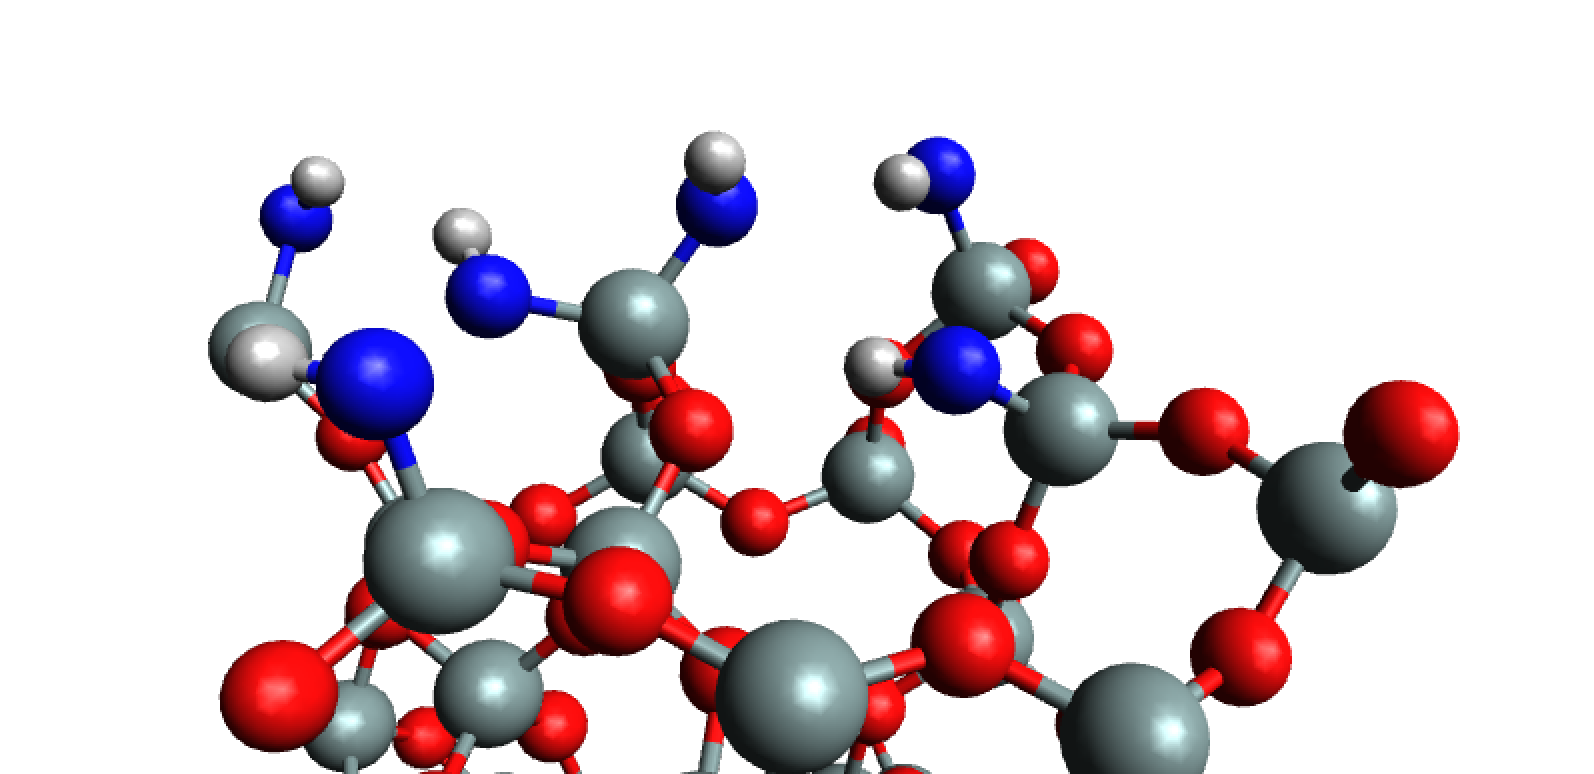

An adsorbate (in this case, let's use TMA, or trimethylaluminum) can bind to any of these OH sites as dimethylaluminum on the surface. Here's an example of one I made by hand and optimized with DFT:

In [18]:
siO2wTMA = xyz2RDmol(cwd + '/50_82_84_opt.xyz')
MolTo3DView([siO2wTMA], ['SiO2 w/ TMA'])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

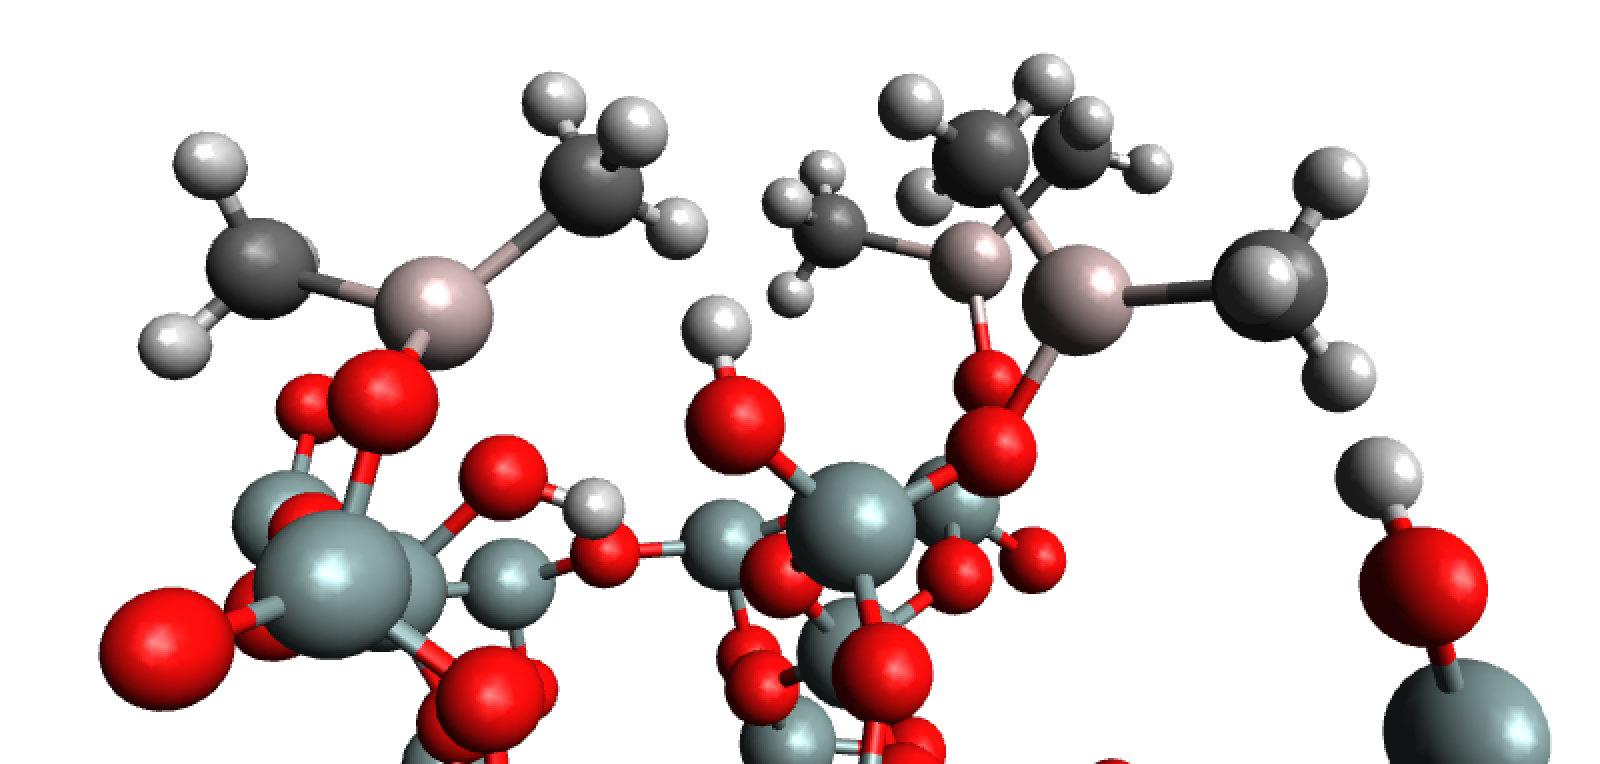

There are 6+15+20+15+6+1=63 binding combinations involving the 6 OH sites. I wrote a program to make all possible combinations, but the DMA adsorbates overlap, and it only provides one possible conformation of many that are possible. I want to make a bunch of different conformations for each binding combination, and I want to do it fast- but for this to work reliably, only the DMA adsorbate should be able to move. How do I optimize the surface TMA, without altering the SiO2 below?

In [24]:
def conf_surf_gen(mol, substrate, charge, mult, method, rms, rand, numConf, pub, filname): 
    fixDict = {mol.GetAtoms()[i].GetIdx():mol.GetConformer().GetAtomPosition(i) for i in range(99)}
    mol_id = AllChem.EmbedMultipleConfs(mol, numConf, pruneRmsThresh=0.1, randomSeed=rand, coordMap=fixDict)
    
conf_surf_gen(siO2wTMA, siO2, 0, 1, AllChem.ETKDGv3(), 0, 1230984, 100, "No", "null")

[20:49:51] Constrained conformer generation (via the coordMap argument) does not work with molecules that have multiple fragments.
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 3
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 4
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 16
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 20
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 21
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 22
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 23
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 24
[20:49:51] UFFTYPER: Unrecognized charge state for atom: 25
[20:49:51] UFFTYPER: Warning: hybridization set to SP3 for atom 92
[20:49:51] UFFTYPER: Warning: hybridization set to SP3 for atom 101
[20:49:51] UFFTYPER: Warning: hybridization set to SP3 for atom 111
[20:54:29] WARNING: not removing hydrogen atom without neighbors
[20:54:29] WARNING: not removing hydrogen atom without neighbor

While normally this would work, it doesn't because I have "Multiple Fragments," probably because this isn't a complete molecule. Any idea what I could do here?